In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class RNN:
    def __init__(self, X_nb_features, y_nb_features, task='generation', data_preprocessing=True,
                 rnn_units=32, activation='tanh', rnn_cell='rnn', kernel_initializer='glorot_normal', dropout=None,
                 opt='rmsprop', lr=0.001, loss='mse'):     
        self.__name__ = 'RNN__many_to_many'

        from keras.models import Sequential
        from keras.layers import Dense, LSTM, SimpleRNN, GRU, Activation, TimeDistributed
        from keras.optimizers import Adam, SGD, RMSprop

        rnn_cell_ = SimpleRNN if rnn_cell == 'rnn' else LSTM if rnn_cell == 'lstm' else GRU if rnn_cell == 'gru' else None

        model = Sequential()
        if dropout is None:
            model.add(rnn_cell_(rnn_units, return_sequences=True, activation=activation,
                                kernel_initializer=kernel_initializer,
                                input_shape=(None, X_nb_features)))
        else:
            model.add(rnn_cell_(rnn_units, return_sequences=True, activation=activation, dropout=dropout,
                                kernel_initializer=kernel_initializer,
                                input_shape=(None, X_nb_features)))
        model.add(TimeDistributed(Dense(y_nb_features)))
        model.add(Activation('linear'))

        opt_ = RMSprop(lr=lr) if opt == 'rmsprop' else Adam(lr=lr) if opt == 'adam' \
            else SGD(lr=lr) if opt == 'sgd' else None
        model.compile(loss=loss, optimizer=opt_)

        self.model = model
        self.data_preprocessing = data_preprocessing
        self.X_scaler, self.y_scaler = None, None
        self.X_features, self.y_features = None, None
        self.task = task  # 'generation', 'translation'

    def fit(self, X, y, epochs=10, sample_weight=None, verbose=1, early_stopping_patience=50):
        if isinstance(X, pd.DataFrame) and isinstance(y, pd.DataFrame):
            from keras.callbacks import ReduceLROnPlateau, EarlyStopping

            X_, y_ = X.copy(), y.copy()

            self.X_features = list(X_.columns)
            self.y_features = list(y_.columns)

            if self.data_preprocessing:
                from sklearn.preprocessing import MinMaxScaler, StandardScaler
                X_stationary = X_.diff().iloc[1:]
                y_stationary = y_.diff().iloc[1:]
                self.X_scaler = StandardScaler()
                self.y_scaler = StandardScaler()
                self.X_scaler.fit(X_stationary.values)
                self.y_scaler.fit(y_stationary.values)
                X_ = pd.DataFrame(data=self.X_scaler.transform(X_stationary.values), index=X_stationary.index, columns=X_stationary.columns)
                y_ = pd.DataFrame(data=self.y_scaler.transform(y_stationary.values), index=y_stationary.index, columns=y_stationary.columns)

            if self.task == 'generation':
                X_ = X_.iloc[:-1]
                y_ = y_.iloc[1:]

            X_ = X_.values.reshape(1, *X_.shape)
            y_ = y_.values.reshape(1, *y_.shape)

            reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=early_stopping_patience//2)
            early_stopping = EarlyStopping(monitor='loss', patience=early_stopping_patience)
            history = self.model.fit(X_, y_, epochs=epochs, callbacks=[reduce_lr, early_stopping],
                                     shuffle=True, sample_weight=sample_weight, verbose=verbose)
            return history

    def predict(self, X, y_first_row=None, error_std=0):
        """
        Predict for Seq2Seq translation
        indicator_keys = X_indicators + y_indicators
        df = get_time_points(session=ses, indicator_keys=indicator_keys).dropna()
        df_train = df.loc[:'2014-03-31'].iloc[:-1]
        model = RNN(
        X_nb_features=len(X_indicators), y_nb_features=len(y_indicators),
        data_preprocessing=True, task='translation',
        activation='tanh', opt='rmsprop', rnn_cell='rnn', rnn_units=32
        )
        # model.model.summary()
        model.fit(X=df_train[X_indicators], y=df_train[y_indicators], epochs=1000, verbose=1)
        y_pred = model.predict(X=df[X_indicators], y_first_row=df[y_indicators].iloc[[0]])
        for col in y_indicators:
            plot_lines([df[col], y_pred[col]], output_filename='../../../data/output/plots/rnn_{}.html'.format(col))
        :param X:
        :param y_first_row:
        :return:
        """
        if isinstance(X, pd.DataFrame):
            X_ = X.copy()
            if self.data_preprocessing:
                X_stationary = X_.diff().iloc[1:]
                X_ = pd.DataFrame(data=self.X_scaler.transform(X_stationary.values), index=X_stationary.index,
                                  columns=X_stationary.columns)

            forecast = self.model.predict(X_.values.reshape(1, *X_.shape))[0]
            # forecast = forecast + np.random.normal(loc=0, scale=error_std, size=forecast.shape)
            # print('forecast', forecast)
            pred = pd.DataFrame(data=forecast, index=X_.index, columns=self.y_features)

            if self.data_preprocessing:
                pred = pd.DataFrame(data=self.y_scaler.inverse_transform(pred), index=pred.index, columns=pred.columns)
                pred = self.diff_inverse_transform(pred, y_first_row)

            return pred

    def rolling_predict(self, X, forecast_horizon=1, error_std=0):
        """
        Predict for sequence generation
        X_indicators = indicator_keys_micro
        y_indicators = indicator_keys_micro
        indicator_keys = list(set(X_indicators) | set(y_indicators))
        df = get_time_points(session=ses, indicator_keys=indicator_keys).dropna(inplace=True)
        df_train = df.loc[:'2014-03-31'].iloc[:-1]
        df_test = df.loc[:'2014-12-31']
        model = RNN(
            X_nb_features=len(X_indicators), y_nb_features=len(y_indicators),
            data_preprocessing=True, task='generation',
            activation='tanh', opt='rmsprop', rnn_cell='rnn', rnn_units=32
        )
        # model.model.summary()
        model.fit(X=df_train[X_indicators], y=df_train[y_indicators], epochs=1000, verbose=1)
        forecast_horizon = 30
        y_pred = model.rolling_predict(X=df_test[X_indicators], forecast_horizon=forecast_horizon)
        y_pred.index = pd.DatetimeIndex(start=df_test.index[-1], periods=forecast_horizon + 1, freq='q')[1:]
        for col in y_indicators:
            plot_lines([df[col], y_pred[col]], output_filename='../../../data/output/plots/rnn_{}.html'.format(col))
        :param X:
        :param forecast_horizon:
        :param error_std:
        :return:
        """
        if isinstance(X, pd.DataFrame):
            X_ = X.copy()

            if self.data_preprocessing:
                X_stationary = X_.diff().iloc[1:]
                X_ = pd.DataFrame(data=self.X_scaler.transform(X_stationary.values), index=X_stationary.index,
                                  columns=X_stationary.columns)

            sample_len = X_.shape[0]
            forecast = X_.values
            for i in range(forecast_horizon):
                x_sample = forecast
                forecast1_ = self.model.predict(x_sample.reshape(1, *x_sample.shape))
                forecast1 = forecast1_[0][[-1]]
                forecast1 = forecast1 + np.random.normal(loc=0, scale=error_std)
                # print('forecast1', forecast1)
                forecast = np.append(forecast, forecast1, axis=0)
            pred = pd.DataFrame(data=forecast[sample_len:], columns=X_.columns)

            if self.data_preprocessing:
                pred = pd.DataFrame(data=self.y_scaler.inverse_transform(pred), columns=pred.columns)
                pred = self.diff_inverse_transform(pred, X.iloc[[-1]])

            return pred

    @staticmethod
    def diff_inverse_transform(df, first_row):
        df_ = first_row
        for i in range(df.shape[0]):
            row = pd.DataFrame(
                data=df.iloc[[i]].values + df_.iloc[[i]].values,
                columns=df_.columns, index=df.iloc[[i]].index)
            df_ = df_.append(row)
        return df_.iloc[1:]

# RNN для задачи генерации последовательности (sequence generation)

### Одномерные данные

In [26]:
df = pd.read_csv('data/international-airline-passengers.csv', index_col=0)
df.index = range(1, len(df)+1)

df.dropna(inplace=True)
df_train = df.loc[:100].iloc[:-1]

X_indicators = ['international_airline_passengers']
y_indicators = ['international_airline_passengers']

### Многомерные данные

In [23]:
df = pd.read_csv('data/all_stocks_2006-01-01_to_2018-01-01.csv', index_col=0)
df.index = range(1, len(df)+1)

df.dropna(inplace=True)
df_train = df.loc[2500:2700].iloc[:-1]

X_indicators = ['AAPL_Close', 'AMZN_Close', 'GOOGL_Close', 'IBM_Close']
y_indicators = ['AAPL_Close', 'AMZN_Close', 'GOOGL_Close', 'IBM_Close']

### Инициализация и обучение модели

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_9 (SimpleRNN)     (None, None, 100)         10200     
_________________________________________________________________
time_distributed_9 (TimeDist (None, None, 1)           101       
_________________________________________________________________
activation_9 (Activation)    (None, None, 1)           0         
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


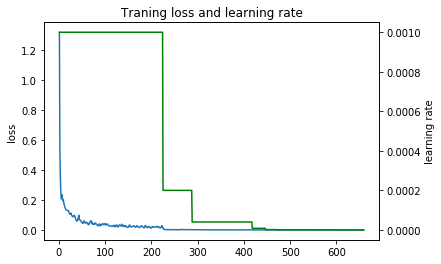

In [27]:
model = RNN(
    X_nb_features=len(X_indicators), y_nb_features=len(y_indicators),
    data_preprocessing=True,
    task='generation',  # 'translation', 'generation'
    rnn_cell='rnn', rnn_units=100, dropout=None,
)
model.model.summary()

learning_history = model.fit(
    X=df_train[X_indicators],
    y=df_train[y_indicators],
    epochs=1000,
    verbose=0
)

# PLOT LOSS
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(range(1, len(learning_history.history['loss'])+1), learning_history.history['loss'])
ax2.plot(range(1, len(learning_history.history['lr'])+1), learning_history.history['lr'], 'g-')
plt.xlabel('epoch'), ax1.set_ylabel('loss'), ax2.set_ylabel('learning rate'), plt.title('Traning loss and learning rate')
plt.show()

### Прогноз модели

international_airline_passengers 

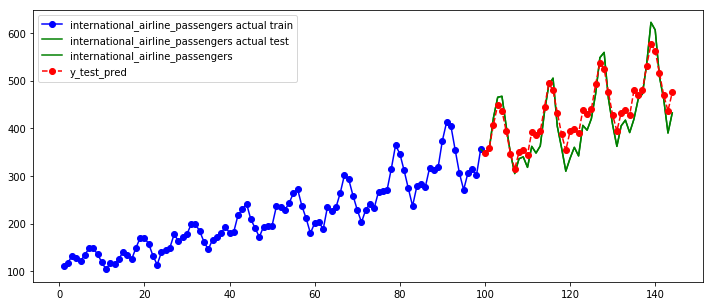

In [28]:
# Generation task
forecast_horizon = df.index[-1] - df_train.index[-1]
y_pred = model.rolling_predict(X=df_train[X_indicators], forecast_horizon=forecast_horizon)
y_pred.index = df.iloc[df_train.index[-1]: df_train.index[-1]+forecast_horizon].index

# PLOT PREDICTIONS
for col in y_indicators:
    print(col, end=' ')
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(df_train.index, df_train[col], 'b-o', label=col + ' actual train')
    ax.plot(df.iloc[len(df_train):].index, df[col].iloc[len(df_train):], 'g-', label=col + ' actual test')
    ax.plot(df.iloc[len(df_train)-1:].index, df[col].iloc[len(df_train)-1:], 'g-')
    ax.plot(y_pred.index, y_pred[col], 'r--o', label='y_test_pred')
    ax.legend(loc='best')
plt.show()

# RNN для задачи перевода (Seq2Seq translation)

### Одномерные данные

In [29]:
df = pd.read_csv('data/international-airline-passengers.csv', index_col=0)
df.index = range(1, len(df)+1)

df['x'] = df.index

df.dropna(inplace=True)
df_train = df.loc[:100].iloc[:-1]

X_indicators = ['x']
y_indicators = ['international_airline_passengers']

### Многомерные данные

In [20]:
df = pd.read_csv('data/all_stocks_2006-01-01_to_2018-01-01.csv', index_col=0)
df.index = range(1, len(df)+1)
df = df.loc[2500:]

df.dropna(inplace=True)
df_train = df.loc[:2700].iloc[:-1]

X_indicators = ['AAPL_Close', 'AMZN_Close', 'GOOGL_Close']
y_indicators = ['IBM_Close']

### Инициализация и обучение модели

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_11 (SimpleRNN)    (None, None, 100)         10200     
_________________________________________________________________
time_distributed_11 (TimeDis (None, None, 1)           101       
_________________________________________________________________
activation_11 (Activation)   (None, None, 1)           0         
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


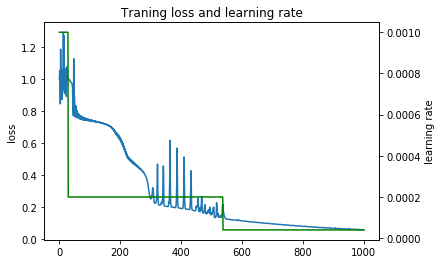

In [32]:
model = RNN(
    X_nb_features=len(X_indicators), y_nb_features=len(y_indicators),
    data_preprocessing=True,
    task='translation',  # 'translation', 'generation'
    rnn_cell='rnn', rnn_units=100, dropout=None,
)
model.model.summary()

learning_history = model.fit(
    X=df_train[X_indicators],
    y=df_train[y_indicators],
    epochs=1000,
    verbose=0
)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(range(1, len(learning_history.history['loss'])+1), learning_history.history['loss'])
ax2.plot(range(1, len(learning_history.history['lr'])+1), learning_history.history['lr'], 'g-')
plt.xlabel('epoch'), ax1.set_ylabel('loss'), ax2.set_ylabel('learning rate'), plt.title('Traning loss and learning rate')
plt.show()

### Прогноз модели

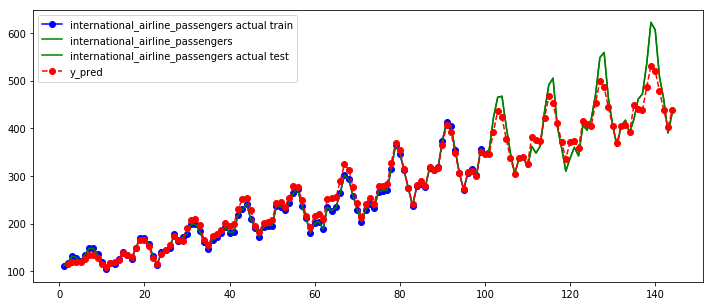

In [33]:
# Translation task
y_pred = model.predict(X=df[X_indicators], y_first_row=df[y_indicators].iloc[[0]])
y_pred.index = df.iloc[1:].index

# PLOT PREDICTIONS
for col in y_indicators:
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(df_train.index, df_train[col], 'b-o', label=col + ' actual train')
    ax.plot(df.index, df[col], 'g-')
    ax.plot(df.loc[df_train.index[-1]:].index, df[col].loc[df_train.index[-1]:], 'g-', label=col + ' actual test')
    ax.plot(y_pred.index, y_pred[col], 'r--o', label='y_pred')
    ax.legend(loc='best')
plt.show()